In [1]:
n_epochs = 5
batch_size = 150
learning_rate = 0.01
l2_reg_coeff = 0.0001

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np; np.random.seed(4)
import tensorflow as tf; tf.set_random_seed(4)

In [3]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train, x_test = x_train.reshape((-1, 784)), x_test.reshape((-1, 784))
x_train, x_test = x_train.astype(np.float32), x_test.astype(np.float32)
y_train_cls = y_train.copy().astype(np.int64).reshape((-1,1))
y_test_cls = y_test.copy().astype(np.int64).reshape((-1,1))
y_train = np.eye(10)[y_train].astype(np.float32)
y_test = np.eye(10)[y_test].astype(np.float32)

In [4]:
tf.reset_default_graph()

In [5]:
def f(a,b,c=1,d=1):
    return a*b+c*d
print(f(2,3)) # 2*3+1*1

from functools import partial
my_f = partial(f, c=2, d=2)
print(my_f(2,3)) # 2*3+2*2

7
10


In [5]:
from functools import partial
init_w = tf.keras.initializers.VarianceScaling(mode="fan_avg") 
l2_reg = tf.contrib.layers.l2_regularizer(l2_reg_coeff)
dense = partial(tf.layers.dense,
                activation=tf.nn.elu,
                kernel_initializer=init_w,
                kernel_regularizer=l2_reg)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [6]:
n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

In [7]:
x = tf.placeholder(tf.float32, shape=[None, n_inputs])

hidden1 = dense(x, n_hidden1)
hidden2 = dense(hidden1, n_hidden2)
hidden3 = dense(hidden2, n_hidden3)
outputs = dense(hidden3, n_outputs, activation=None)

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.


In [12]:
reconstruction_loss = tf.reduce_mean(tf.square(outputs - x))
reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
loss = tf.add_n([reconstruction_loss] + reg_losses)

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver() # not shown in the book

In [13]:
def shuffle_batch(x, y, batch_size):
    rnd_idx = np.random.permutation(len(x))
    n_batches = len(x) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        yield x[batch_idx], y[batch_idx]

In [14]:
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for x_batch, _ in shuffle_batch(x_train, y_train_cls, batch_size):
            feed_dict = {x: x_batch}
            sess.run(training_op, feed_dict=feed_dict)
        loss_train = reconstruction_loss.eval(feed_dict=feed_dict)   
        print("\r{}".format(epoch), "Train MSE:", loss_train)           
    saver.save(sess, "./my_model_all_layers.ckpt")                  

0 Train MSE: 0.022484737
1 Train MSE: 0.01401295
2 Train MSE: 0.012062215
3 Train MSE: 0.012005134
4 Train MSE: 0.012288441


In [15]:
def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), 
               cmap=plt.cm.binary, 
               interpolation="nearest")
    plt.axis("off")

In [16]:
def show_reconstructed_digits(model_path=None, n_test_digits=2):
    with tf.Session() as sess:
        if model_path:
            saver.restore(sess, model_path)
        x_test_ = x_test[:n_test_digits]
        outputs_val = outputs.eval(feed_dict={x: x_test_})

    fig = plt.figure(figsize=(8, 3 * n_test_digits))
    for digit_index in range(n_test_digits):
        plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
        plot_image(x_test_[digit_index])
        plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
        plot_image(outputs_val[digit_index])

INFO:tensorflow:Restoring parameters from ./my_model_all_layers.ckpt


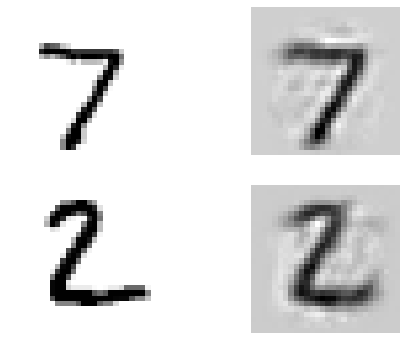

In [17]:
show_reconstructed_digits(model_path="./my_model_all_layers.ckpt")
#save_fig("reconstruction_plot")